# Swansea City 2024/25 – One Page Summary (BigQuery Source)

This notebook builds a one-page style summary for **Swansea City** using
BigQuery tables:

- `player_stats_semantic_2024_25`
- `league_table_enhanced_2024_25`

It shows:

1. Team profile vs league (points, xG, goals, possession, progression, net spend)
2. Swansea player attacking contribution (xG+xAG vs G+A per 90)
3. Swansea ball progression map (progressive passes vs carries per 90)
4. Minutes & role distribution (who actually plays)


In [1]:
import sys
from pathlib import Path

# ------------------------------------------------
# Make sure project root (where config.py lives)
# is on sys.path so we can import `config`
# ------------------------------------------------
ROOT = Path.cwd().parent  # notebooks/ -> parent is project root
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print("Project root on sys.path:", ROOT)

from src.config import GCP_PROJECT_ID, BQ_DATASET

print("GCP project:", GCP_PROJECT_ID)
print("BQ dataset :", BQ_DATASET)

# BigQuery client + table names
from google.cloud import bigquery
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

client = bigquery.Client(project=GCP_PROJECT_ID)

TABLE_PLAYERS = f"{GCP_PROJECT_ID}.{BQ_DATASET}.player_stats_semantic_2024_25"
TABLE_LEAGUE  = f"{GCP_PROJECT_ID}.{BQ_DATASET}.league_table_enhanced_2024_25"

print("Players table:", TABLE_PLAYERS)
print("League table :", TABLE_LEAGUE)


Project root on sys.path: /Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline
GCP project: swansea-478816
BQ dataset : championship_2024_25
Players table: swansea-478816.championship_2024_25.player_stats_semantic_2024_25
League table : swansea-478816.championship_2024_25.league_table_enhanced_2024_25


In [2]:
players_query = f"SELECT * FROM `{TABLE_PLAYERS}`"
league_query  = f"SELECT * FROM `{TABLE_LEAGUE}`"

players = client.query(players_query).to_dataframe()
league  = client.query(league_query).to_dataframe()

print("Players shape:", players.shape)
print("League shape :", league.shape)

players.head(), league.head()


/Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Players shape: (765, 37)
League shape : (24, 48)


(   club_id          club        player_name nationality position   age  \
 0       21    Sunderland  Salis Abdul Samed       Ghana       MF  24.0   
 1       23       Watford   Michael Adu-Poku     England       FW  18.0   
 2        4  Cardiff City        Jak Alnwick     England       GK  31.0   
 3       21    Sunderland       Joe Anderson     England       DF  23.0   
 4       15    Portsmouth      Jordan Archer    Scotland       GK  31.0   
 
      born  mp  starts   min  ...  p90_ast  p90_g+a  p90_g-pk  p90_g+a-pk  \
 0  2000.0  10       3   283  ...      0.0      0.0       0.0         0.0   
 1  2005.0   1       0     1  ...      0.0      0.0       0.0         0.0   
 2  1993.0  29      29  2610  ...      0.0      0.0       0.0         0.0   
 3  2001.0   2       1    99  ...      0.0      0.0       0.0         0.0   
 4  1993.0   2       1   150  ...      0.0      0.0       0.0         0.0   
 
    p90_xg  p90_xag  p90_xg+xag  p90_npxg  p90_npxg+xag  \
 0     0.0     0.01      

In [3]:
# Robust Swansea detection in league table
clubs = league["club"].astype(str).str.strip()
matches = [c for c in clubs.unique() if "swansea" in c.lower()]

if not matches:
    raise ValueError("Could not find any club containing 'Swansea' in league table.")

SWANSEA_NAME = matches[0]
print("Detected Swansea club name:", SWANSEA_NAME)

swansea_team = league[league["club"] == SWANSEA_NAME].iloc[0]

# Ensure a 'matches played' column
if "played" in league.columns:
    league["matches"] = league["played"]
elif "squad_mp" in league.columns:
    league["matches"] = league["squad_mp"]
else:
    raise ValueError("Could not find a matches/played column in league_table_enhanced.")

def has(col: str) -> bool:
    return col in league.columns

team_metrics = []

# Points per game
if has("pts") and has("matches"):
    league["pts_per_game"] = league["pts"] / league["matches"]
    team_metrics.append(("pts_per_game", "Points per game"))

# xG for per game
if has("squad_xg") and has("matches"):
    league["squad_xg_per_game"] = league["squad_xg"] / league["matches"]
    team_metrics.append(("squad_xg_per_game", "xG for per game"))

# Goals for per game
if has("goals_for") and has("matches"):
    league["gf_per_game"] = league["goals_for"] / league["matches"]
    team_metrics.append(("gf_per_game", "Goals for per game"))

# Defence (invert GA so higher is better)
if has("goals_against") and has("matches"):
    league["ga_per_game"] = league["goals_against"] / league["matches"]
    league["ga_prevented_score"] = -league["ga_per_game"]
    team_metrics.append(("ga_prevented_score", "Defence (lower GA better)"))

# Possession
if has("squad_poss"):
    team_metrics.append(("squad_poss", "Possession %"))

# Progressive passes p90
if has("squad_prgp") and has("squad_90s"):
    league["squad_prgp_p90"] = league["squad_prgp"] / league["squad_90s"]
    team_metrics.append(("squad_prgp_p90", "Progressive passes p90"))

# Progressive carries p90
if has("squad_prgc") and has("squad_90s"):
    league["squad_prgc_p90"] = league["squad_prgc"] / league["squad_90s"]
    team_metrics.append(("squad_prgc_p90", "Progressive carries p90"))

# Net spend
if has("net_spend_eur"):
    team_metrics.append(("net_spend_eur", "Net spend (€)"))

team_metrics


Detected Swansea club name: Swansea City


[('pts_per_game', 'Points per game'),
 ('squad_xg_per_game', 'xG for per game'),
 ('gf_per_game', 'Goals for per game'),
 ('ga_prevented_score', 'Defence (lower GA better)'),
 ('squad_poss', 'Possession %'),
 ('squad_prgp_p90', 'Progressive passes p90'),
 ('squad_prgc_p90', 'Progressive carries p90'),
 ('net_spend_eur', 'Net spend (€)')]

In [4]:
import pandas as pd
import numpy as np

# Robust Swansea detection in league table
clubs = league["club"].astype(str).str.strip()
matches = [c for c in clubs.unique() if "swansea" in c.lower()]

if not matches:
    raise ValueError("Could not find any club containing 'Swansea' in league table.")

SWANSEA_NAME = matches[0]
print("Detected Swansea club name:", SWANSEA_NAME)

# Ensure a 'matches played' column
if "played" in league.columns:
    league["matches"] = league["played"]
elif "squad_mp" in league.columns:
    league["matches"] = league["squad_mp"]
else:
    raise ValueError("Could not find a matches/played column in league_table_enhanced.")

def has(col: str) -> bool:
    return col in league.columns

team_metrics: list[tuple[str, str]] = []

# Points per game
if has("pts") and has("matches"):
    league["pts_per_game"] = league["pts"] / league["matches"]
    team_metrics.append(("pts_per_game", "Points per game"))

# xG for per game
if has("squad_xg") and has("matches"):
    league["squad_xg_per_game"] = league["squad_xg"] / league["matches"]
    team_metrics.append(("squad_xg_per_game", "xG for per game"))

# Goals for per game
if has("goals_for") and has("matches"):
    league["gf_per_game"] = league["goals_for"] / league["matches"]
    team_metrics.append(("gf_per_game", "Goals for per game"))

# Defence (invert GA so higher is better)
if has("goals_against") and has("matches"):
    league["ga_per_game"] = league["goals_against"] / league["matches"]
    league["ga_prevented_score"] = -league["ga_per_game"]
    team_metrics.append(("ga_prevented_score", "Defence (lower GA better)"))

# Possession
if has("squad_poss"):
    team_metrics.append(("squad_poss", "Possession %"))

# Progressive passes p90
if has("squad_prgp") and has("squad_90s"):
    league["squad_prgp_p90"] = league["squad_prgp"] / league["squad_90s"]
    team_metrics.append(("squad_prgp_p90", "Progressive passes p90"))

# Progressive carries p90
if has("squad_prgc") and has("squad_90s"):
    league["squad_prgc_p90"] = league["squad_prgc"] / league["squad_90s"]
    team_metrics.append(("squad_prgc_p90", "Progressive carries p90"))

# Net spend
if has("net_spend_eur"):
    team_metrics.append(("net_spend_eur", "Net spend (€)"))

print("Team metrics to compare:", team_metrics)


Detected Swansea club name: Swansea City
Team metrics to compare: [('pts_per_game', 'Points per game'), ('squad_xg_per_game', 'xG for per game'), ('gf_per_game', 'Goals for per game'), ('ga_prevented_score', 'Defence (lower GA better)'), ('squad_poss', 'Possession %'), ('squad_prgp_p90', 'Progressive passes p90'), ('squad_prgc_p90', 'Progressive carries p90'), ('net_spend_eur', 'Net spend (€)')]


In [5]:
# Re-select Swansea row *after* all derived metrics are added
swansea_row = league[league["club"] == SWANSEA_NAME].iloc[0]

rows = []
for col, label in team_metrics:
    if col not in league.columns:
        continue
    sw_val = swansea_row[col]
    league_median = league[col].median()
    ratio = sw_val / league_median if pd.notna(league_median) and league_median != 0 else np.nan
    rows.append(
        {
            "metric_col": col,
            "metric": label,
            "swansea_value": sw_val,
            "league_median": league_median,
            "ratio_vs_median": ratio,
        }
    )

team_df = pd.DataFrame(rows)
team_df


,metric_col,metric,swansea_value,league_median,ratio_vs_median
0,pts_per_game,Points per game,1.326087e+00,1.250000,1.060870
1,squad_xg_per_game,xG for per game,1.226087e+00,1.208696,1.014388
2,gf_per_game,Goals for per game,1.108696e+00,1.152174,0.962264
3,ga_prevented_score,Defence (lower GA better),-1.217391e+00,-1.239130,0.982456
4,squad_poss,Possession %,5.760000e+01,49.150000,1.171923
5,squad_prgp_p90,Progressive passes p90,3.689130e+01,31.836957,1.158757
6,squad_prgc_p90,Progressive carries p90,1.741304e+01,14.565217,1.195522
7,net_spend_eur,Net spend (€),1.430000e+06,-965000.000000,-1.481865


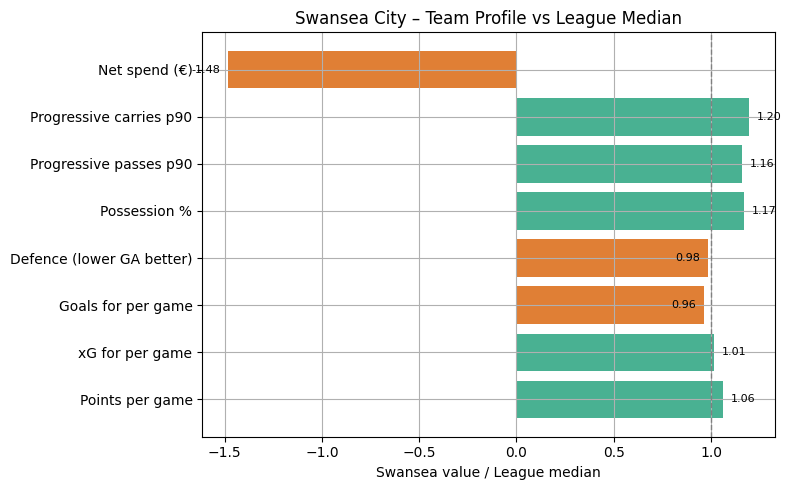

In [6]:
plt.figure(figsize=(8, 5))

y_pos = np.arange(len(team_df))
ratios = team_df["ratio_vs_median"].values

plt.axvline(1.0, color="gray", linestyle="--", linewidth=1)

bars = plt.barh(
    y_pos,
    ratios,
    color=np.where(ratios >= 1.0, "#1b9e77", "#d95f02"),
    alpha=0.8,
)

plt.yticks(y_pos, team_df["metric"])
plt.xlabel("Swansea value / League median")
plt.title(f"{SWANSEA_NAME} – Team Profile vs League Median")

for i, r in enumerate(ratios):
    if np.isnan(r):
        continue
    x_text = r + 0.04 if r >= 1 else r - 0.04
    ha = "left" if r >= 1 else "right"
    plt.text(
        x_text,
        i,
        f"{r:.2f}",
        va="center",
        ha=ha,
        fontsize=8,
    )

plt.tight_layout()
plt.show()


In [7]:
# Swansea players (robust match on club name)
swansea_players = players[players["club"].astype(str).str.lower().str.contains("swansea")].copy()
print("Players for Swansea:", len(swansea_players))

# Ensure per-90 contributions
if "p90_xg_xag" not in swansea_players.columns:
    if {"p90_xg", "p90_xag"}.issubset(swansea_players.columns):
        swansea_players["p90_xg_xag"] = swansea_players["p90_xg"] + swansea_players["p90_xag"]
    else:
        raise ValueError("Missing p90_xg and/or p90_xag in player stats.")

if "p90_ga" not in swansea_players.columns:
    if "p90_g+a" in swansea_players.columns:
        swansea_players["p90_ga"] = swansea_players["p90_g+a"]
    else:
        raise ValueError("Missing p90_g+a column for G+A per 90.")

if "90s" not in swansea_players.columns:
    raise ValueError("Expected '90s' column in player stats.")

# Only players with at least 3 full matches (3 x 90 mins)
swansea_players = swansea_players[swansea_players["90s"] >= 3].copy()
print("After 3+ 90s filter:", len(swansea_players))

swansea_players[
    ["player_name", "position", "90s", "g+a", "p90_xg_xag", "p90_ga"]
].sort_values("g+a", ascending=False).head(10)


Players for Swansea: 26
After 3+ 90s filter: 21


,player_name,position,90s,g+a,p90_xg_xag,p90_ga
746,Liam Cullen,"MF,FW",33.3,14,0.38,0.42
561,Josh Tymon,DF,43.8,9,0.29,0.21
588,Ronald,"FW,MF",41.8,9,0.25,0.22
686,Harry Darling,DF,37.1,8,0.16,0.22
723,Žan Vipotnik,FW,23.2,7,0.45,0.30
630,Myles Peart-Harris,"FW,MF",18.5,7,0.29,0.38
651,Eom Jisung,"FW,MF",25.4,5,0.37,0.20
465,Josh Key,DF,38.5,4,0.10,0.10
590,Gonçalo Franco,MF,34.9,4,0.18,0.11
642,Florian Bianchini,FW,12.3,3,0.45,0.24


In [16]:
import re
import matplotlib.cm as cm

# Order used to normalise multi-role labels
ROLE_ORDER = ["GK", "DF", "MF", "FW", "Other"]

def _map_token_to_role(token: str) -> str:
    """Map a single raw token (e.g. 'AM', 'WB') to a coarse role."""
    t = token.upper()

    # Forwards
    if t.startswith(("FW", "ST", "CF")):
        return "FW"

    # Midfielders
    if t.startswith(("MF", "AM", "DM", "CM", "LM", "RM")):
        return "MF"

    # Defenders
    if t.startswith(("DF", "FB", "WB", "CB", "RB", "LB")):
        return "DF"

    # Goalkeepers
    if t.startswith("GK"):
        return "GK"

    return "Other"


def simplify_pos(pos: str) -> str:
    """
    Simplify position strings into:
      - single roles: 'FW', 'MF', 'DF', 'GK', 'Other'
      - or hybrid roles: 'FW/MF', 'DF/MF', etc.

    'MF, FW' and 'FW, MF' both become 'FW/MF' (order normalised).
    """
    if not isinstance(pos, str):
        return "Other"

    # Split on commas, slashes, semicolons, whitespace
    tokens = re.split(r"[,/; ]+", pos)
    tokens = [t for t in tokens if t]

    if not tokens:
        return "Other"

    roles = {_map_token_to_role(tok) for tok in tokens}

    # If we have recognised roles + "Other", drop "Other"
    if len(roles) > 1 and "Other" in roles:
        roles.discard("Other")

    if not roles:
        return "Other"

    # Single-role case
    if len(roles) == 1:
        return next(iter(roles))

    # Multi-role case → stable label like 'DF/MF' or 'DF/MF/FW'
    ordered = [r for r in ROLE_ORDER if r in roles]
    return "/".join(ordered)


# Ensure pos_group exists on Swansea players
swansea_players["pos_group"] = swansea_players["position"].apply(simplify_pos)

# Build a distinct colour for each pos_group (single or hybrid)
pos_groups = sorted(swansea_players["pos_group"].dropna().unique())
n_groups = len(pos_groups)

base_colors = {
    "FW": np.array([1.0, 0.2, 0.2]),
    "MF": np.array([0.2, 0.4, 1.0]),
    "DF": np.array([0.2, 1.0, 0.4]),
    "GK": np.array([0.0, 0.0, 0.0]),
    "Other": np.array([0.7, 0.7, 0.7]),
}

def blend_roles(role_label):
    roles = role_label.split("/")
    cols = [base_colors.get(r, base_colors["Other"]) for r in roles]
    return tuple(np.mean(cols, axis=0))

pos_palette = {group: blend_roles(group) for group in pos_groups}

pos_groups, pos_palette


(['DF', 'FW', 'GK', 'MF', 'MF/FW'],
 {'DF': (np.float64(0.2), np.float64(1.0), np.float64(0.4)),
  'FW': (np.float64(1.0), np.float64(0.2), np.float64(0.2)),
  'GK': (np.float64(0.0), np.float64(0.0), np.float64(0.0)),
  'MF': (np.float64(0.2), np.float64(0.4), np.float64(1.0)),
  'MF/FW': (np.float64(0.6),
   np.float64(0.30000000000000004),
   np.float64(0.6))})

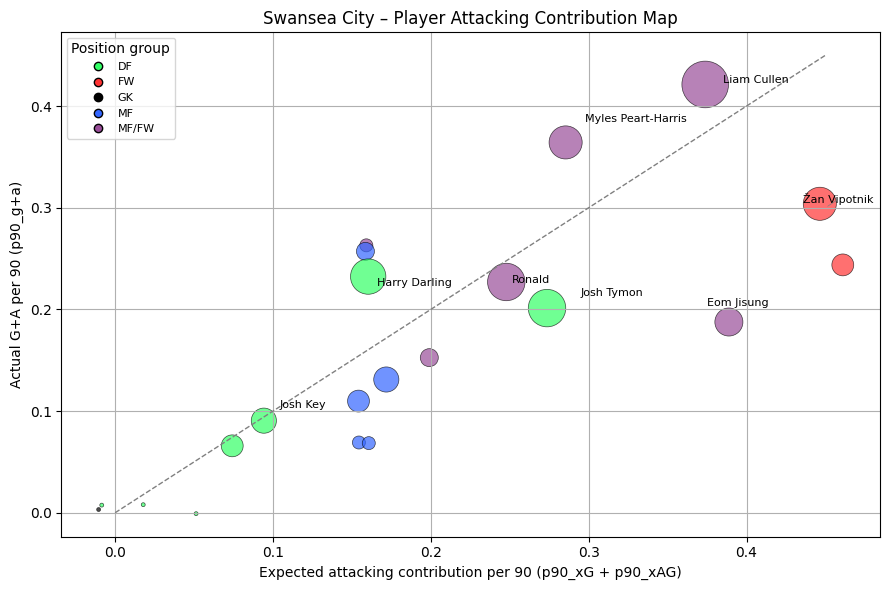

In [17]:
df_plot = swansea_players.copy()

colors = df_plot["pos_group"].map(pos_palette)
size_factor = 80
sizes = (df_plot["g+a"].fillna(0) + 0.1) * size_factor

plt.figure(figsize=(9, 6))

# Jitter to reduce overlap
jitter_x = 0.01
jitter_y = 0.01

x_j = df_plot["p90_xg_xag"] + np.random.normal(0, jitter_x, len(df_plot))
y_j = df_plot["p90_ga"] + np.random.normal(0, jitter_y, len(df_plot))

plt.scatter(
    x_j,
    y_j,
    s=sizes,
    c=colors,
    alpha=0.7,
    edgecolor="k",
    linewidth=0.5,
)

plt.xlabel("Expected attacking contribution per 90 (p90_xG + p90_xAG)")
plt.ylabel("Actual G+A per 90 (p90_g+a)")
plt.title(f"{SWANSEA_NAME} – Player Attacking Contribution Map")
plt.grid(True)

# 1:1 diagonal using TRUE values
val_min = min(df_plot["p90_xg_xag"].min(), df_plot["p90_ga"].min())
val_max = max(df_plot["p90_xg_xag"].max(), df_plot["p90_ga"].max())
diag = np.linspace(val_min, val_max, 200)
plt.plot(diag, diag, linestyle="--", color="gray", linewidth=1)

# Non-overlapping labels: top 8 by total G+A
top = df_plot.sort_values("g+a", ascending=False).head(8)

texts = []
for _, row in top.iterrows():
    texts.append(
        plt.text(
            row["p90_xg_xag"],
            row["p90_ga"],
            row["player_name"],
            fontsize=8,
            weight="medium",
        )
    )

adjust_text(
    texts,
    expand_points=(1.2, 1.3),
    expand_text=(1.1, 1.2),
    arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5),
)

# Legend: one entry per pos_group (including hybrids)
handles = []
labels = []

for group in pos_groups:
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markerfacecolor=pos_palette[group],
            markeredgecolor="k",
            markersize=6,
        )
    )
    labels.append(group)

plt.legend(handles, labels, title="Position group", loc="best", fontsize=8)

plt.tight_layout()
plt.show()


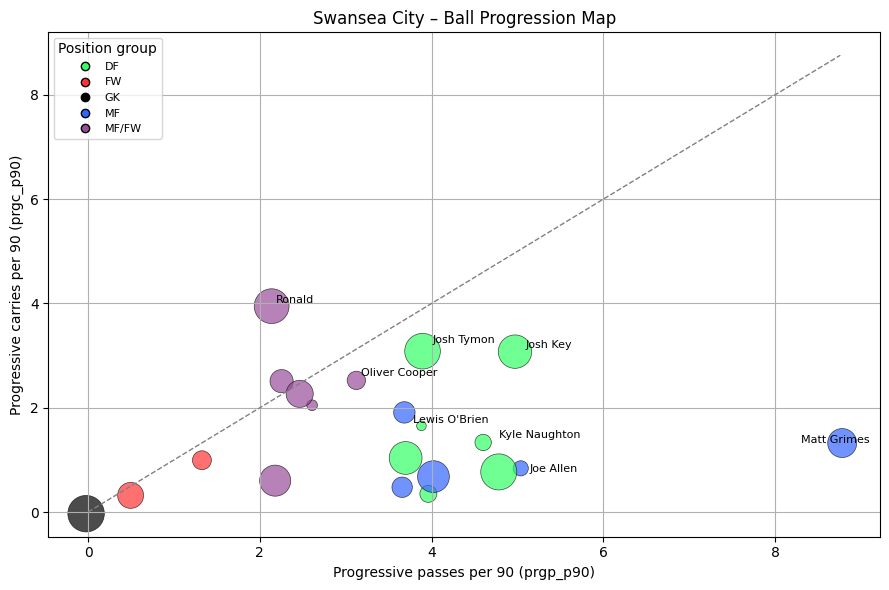

In [18]:
required_prog = ["prgc", "prgp", "90s"]
missing = [c for c in required_prog if c not in swansea_players.columns]
if missing:
    raise ValueError(f"Missing progression columns for Swansea players: {missing}")

df_prog = swansea_players.copy()
df_prog["prgc_p90"] = df_prog["prgc"] / df_prog["90s"]
df_prog["prgp_p90"] = df_prog["prgp"] / df_prog["90s"]

plt.figure(figsize=(9, 6))

sizes = (df_prog["90s"].fillna(0) + 0.1) * 15  # bigger = more minutes
colors = df_prog["pos_group"].map(pos_palette)

# jitter
jitter_x = 0.05
jitter_y = 0.05

x_j = df_prog["prgp_p90"] + np.random.normal(0, jitter_x, len(df_prog))
y_j = df_prog["prgc_p90"] + np.random.normal(0, jitter_y, len(df_prog))

plt.scatter(
    x_j,
    y_j,
    s=sizes,
    c=colors,
    alpha=0.7,
    edgecolor="k",
    linewidth=0.5,
)

plt.xlabel("Progressive passes per 90 (prgp_p90)")
plt.ylabel("Progressive carries per 90 (prgc_p90)")
plt.title(f"{SWANSEA_NAME} – Ball Progression Map")
plt.grid(True)

# diagonal where prgp_p90 == prgc_p90
val_min = min(df_prog["prgp_p90"].min(), df_prog["prgc_p90"].min())
val_max = max(df_prog["prgp_p90"].max(), df_prog["prgc_p90"].max())
diag = np.linspace(val_min, val_max, 200)
plt.plot(diag, diag, linestyle="--", color="gray", linewidth=1)

# label top 8 progressors by (prgp_p90 + prgc_p90)
df_prog["prog_sum"] = df_prog["prgp_p90"] + df_prog["prgc_p90"]
top_prog = df_prog.sort_values("prog_sum", ascending=False).head(8)

texts = []
for _, row in top_prog.iterrows():
    texts.append(
        plt.text(
            row["prgp_p90"],
            row["prgc_p90"],
            row["player_name"],
            fontsize=8,
            weight="medium",
        )
    )

adjust_text(
    texts,
    expand_points=(1.2, 1.3),
    expand_text=(1.1, 1.2),
    arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5),
)

# Legend: same pos_groups / pos_palette
handles = []
labels = []

for group in pos_groups:
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markerfacecolor=pos_palette[group],
            markeredgecolor="k",
            markersize=6,
        )
    )
    labels.append(group)

plt.legend(handles, labels, title="Position group", loc="best", fontsize=8)

plt.tight_layout()
plt.show()


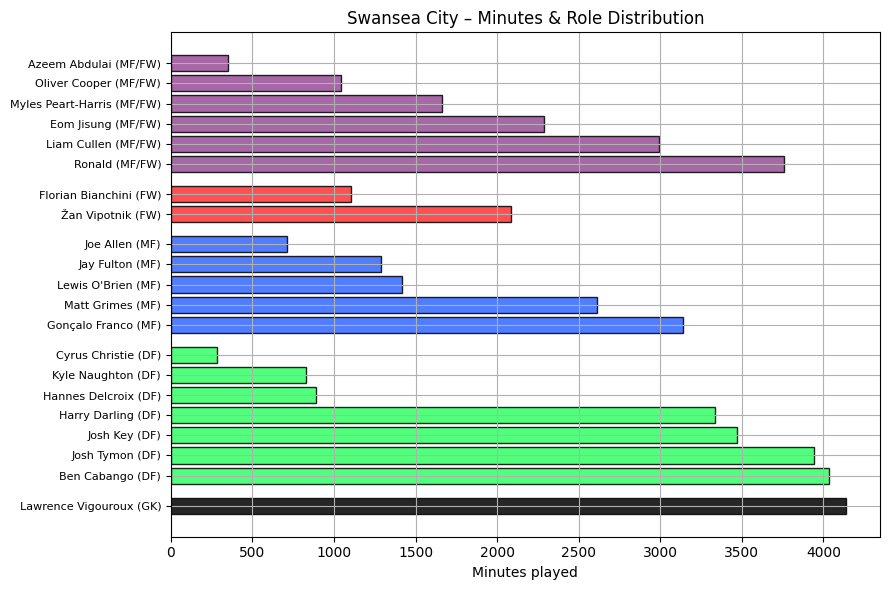

In [19]:
df_min = swansea_players.copy()

if "min" not in df_min.columns:
    raise ValueError("Expected 'min' column with total minutes in player stats.")

df_min = df_min.sort_values(["pos_group", "min"], ascending=[True, False])

plt.figure(figsize=(9, 6))

y_labels = []
y_pos = []
bar_pos = 0

# Order groups: base roles first, then hybrids/others sorted
base_order = ROLE_ORDER  # ["GK", "DF", "MF", "FW", "Other"]
all_groups = list(df_min["pos_group"].dropna().unique())

ordered_groups = [g for g in base_order if g in all_groups] + sorted(
    [g for g in all_groups if g not in base_order]
)

for pos_group in ordered_groups:
    group = df_min[df_min["pos_group"] == pos_group]
    if group.empty:
        continue
    for _, row in group.iterrows():
        plt.barh(
            bar_pos,
            row["min"],
            color=pos_palette.get(pos_group, (0.6, 0.6, 0.6, 1.0)),
            edgecolor="k",
            alpha=0.85,
        )
        y_labels.append(f"{row['player_name']} ({pos_group})")
        y_pos.append(bar_pos)
        bar_pos += 1
    bar_pos += 0.5  # gap between groups

plt.yticks(y_pos, y_labels, fontsize=8)
plt.xlabel("Minutes played")
plt.title(f"{SWANSEA_NAME} – Minutes & Role Distribution")

plt.tight_layout()
plt.show()


In [20]:
summary_lines = []

# Re-select Swansea row from league
swansea_row = league[league["club"] == SWANSEA_NAME].iloc[0]

if "pts_per_game" in league.columns:
    league_sorted = league.sort_values("pts_per_game", ascending=False).reset_index(drop=True)
    sw_idx = league_sorted[league_sorted["club"] == SWANSEA_NAME].index[0] + 1
    summary_lines.append(
        f"- {SWANSEA_NAME} rank **{sw_idx}** in points per game "
        f"({swansea_row['pts_per_game']:.2f} pts/game)."
    )

if "squad_xg_per_game" in league.columns:
    league_sorted = league.sort_values("squad_xg_per_game", ascending=False).reset_index(drop=True)
    sw_idx = league_sorted[league_sorted["club"] == SWANSEA_NAME].index[0] + 1
    summary_lines.append(
        f"- They rank **{sw_idx}** in xG for per game "
        f"({swansea_row['squad_xg_per_game']:.2f} xG/game)."
    )

if "squad_poss" in league.columns:
    poss_med = league["squad_poss"].median()
    direction = "above" if swansea_row["squad_poss"] > poss_med else "below"
    summary_lines.append(
        f"- Average possession is **{swansea_row['squad_poss']:.1f}%**, {direction} the league median."
    )

print(f"Summary for {SWANSEA_NAME}:\n")
for line in summary_lines:
    print(line)


Summary for Swansea City:

- Swansea City rank **11** in points per game (1.33 pts/game).
- They rank **11** in xG for per game (1.23 xG/game).
- Average possession is **57.6%**, above the league median.
